<a href="https://colab.research.google.com/github/yoonju977/Personalize_Medic_chatbot/blob/main/ko_bert_24K_symptom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
ko-bert 모델을 사용하여 "/content/drive/MyDrive/의료기기_검색_서비스/Dataset_FIN.gsheet" 경로에 있는 질병별 한국어 증상 데이터를 학습하고 테스트합니다. 데이터는 각 질병(label)별로 7:1.5:1.5 비율로 랜덤하게 train, validation, test 세트로 분할합니다. 학습 과정에서는 각 에포크마다 train 및 validation의 러닝 커브와 수치를 출력하고, 테스트 결과에서는 각 질병별 및 전체 f1, recall, precision 지표를 출력합니다.

## Google sheet에서 데이터 로드

### Subtask:
Google Sheet에서 데이터를 로드하여 pandas DataFrame으로 변환합니다.


In [2]:
!pip install gspread-dataframe

In [5]:
import gspread
from google.colab import auth
import pandas as pd
import google.auth

# Authenticate to Google
auth.authenticate_user()
credentials, project_id = google.auth.default()
gc = gspread.authorize(credentials)

# Open the spreadsheet
try:
    # Assuming the sheet title is "Dataset_FIN"
    spreadsheet = gc.open("Dataset_FIN")
    worksheet = spreadsheet.sheet1  # Assuming the data is in the first sheet

    # Get all values from the worksheet
    data = worksheet.get_all_values()

    # Convert the data to a pandas DataFrame
    # The first row is assumed to be the header
    df = pd.DataFrame(data[1:], columns=data[0])

    display(df.head())
except Exception as e:
    print(f"Error loading data from Google Sheet: {e}")
    print("Please ensure the Google Sheet title is 'Dataset_FIN' and the service account has access.")
    df = None # Set df to None to indicate failure

,label,text
0,간염,온몸이 나른하고 얼굴이 누렇게 뜨고 한기가 들어서 소름이 돋을 때가 있어요.
1,간염,"밤만 되면 머리가 무겁고 대변 색이 평소보다 많이 옅어요, 피부가 점점 누렇게 보여요."
2,간염,대변 색이 옅어지고 입맛이 떨어지고 대변 색이 평소보다 많이 옅어요.
3,간염,"최근에 쉽게 피로해지고 속이 늘 더부룩해요, 피곤이 전혀 풀리지 않아요."
4,간염,몇 주째 소변 색이 진해지고 구역질이 나고 그래서 집안일을 거의 못 하고 있어요.


## 데이터 전처리

### Subtask:
필요한 열만 선택하고, 데이터에 대한 기본적인 전처리를 수행합니다.


In [6]:
# 1. Select 'label' and 'text' columns
df = df[['label', 'text']]

# 2. Check for missing values and remove rows with missing values
print("Original DataFrame shape:", df.shape)
df.dropna(inplace=True)
print("DataFrame shape after dropping NaNs:", df.shape)

# 3. Convert 'text' column to string type
df['text'] = df['text'].astype(str)

# 4. Remove leading/trailing whitespace from 'text' column
df['text'] = df['text'].str.strip()

# 5. Check unique values in 'label' column
unique_labels = df['label'].unique()
print("\nUnique labels:", unique_labels)
print("Number of unique labels:", len(unique_labels))

# Display the first few rows of the cleaned DataFrame
display(df.head())

Original DataFrame shape: (21000, 2)
DataFrame shape after dropping NaNs: (21000, 2)

Unique labels: ['간염' '갑상선기능항진증' '고혈압' '골다공증' '노인성빈혈' '노인성우울증' '녹내장' '뇌동맥류' '뇌졸중' '당뇨병'
 '동맥경화' '류마티스 관절염' '변비' '신장병' '오십견' '요통' '위장병' '치매' '통풍' '퇴행성근골격계질환'
 '파킨슨병']
Number of unique labels: 21


,label,text
0,간염,온몸이 나른하고 얼굴이 누렇게 뜨고 한기가 들어서 소름이 돋을 때가 있어요.
1,간염,"밤만 되면 머리가 무겁고 대변 색이 평소보다 많이 옅어요, 피부가 점점 누렇게 보여요."
2,간염,대변 색이 옅어지고 입맛이 떨어지고 대변 색이 평소보다 많이 옅어요.
3,간염,"최근에 쉽게 피로해지고 속이 늘 더부룩해요, 피곤이 전혀 풀리지 않아요."
4,간염,몇 주째 소변 색이 진해지고 구역질이 나고 그래서 집안일을 거의 못 하고 있어요.


## 데이터 분할

### Subtask:
각 질병(label)별로 데이터를 train, validation, test 세트로 7:1.5:1.5 비율로 랜덤하게 분할합니다.


In [7]:
from sklearn.model_selection import train_test_split

train_dfs = []
val_dfs = []
test_dfs = []

In [8]:
random_state = 42

for label in df['label'].unique():
    # Filter data for the current label
    df_label = df[df['label'] == label]

    # Split into initial train (70%) and temporary (30%)
    df_train, df_temp = train_test_split(
        df_label,
        test_size=0.3,
        random_state=random_state,
        stratify=df_label['label'] # Stratify even for single label for consistency
    )

    # Split temporary into validation (15%) and test (15%)
    df_val, df_test = train_test_split(
        df_temp,
        test_size=0.5, # 0.5 of 30% is 15%
        random_state=random_state,
        stratify=df_temp['label'] # Stratify even for single label for consistency
    )

    train_dfs.append(df_train)
    val_dfs.append(df_val)
    test_dfs.append(df_test)

In [9]:
import pandas as pd

# Concatenate the dataframes
df_train = pd.concat(train_dfs)
df_val = pd.concat(val_dfs)
df_test = pd.concat(test_dfs)

# Shuffle the dataframes
df_train = df_train.sample(frac=1, random_state=random_state).reset_index(drop=True)
df_val = df_val.sample(frac=1, random_state=random_state).reset_index(drop=True)
df_test = df_test.sample(frac=1, random_state=random_state).reset_index(drop=True)

# Print the shapes
print("Shape of train_df:", df_train.shape)
print("Shape of val_df:", df_val.shape)
print("Shape of test_df:", df_test.shape)

Shape of train_df: (14700, 2)
Shape of val_df: (3150, 2)
Shape of test_df: (3150, 2)


## Ko-bert 모델 로드

### Subtask:
Ko-BERT 모델과 토크나이저를 로드합니다.


In [10]:
from transformers import BertModel, BertTokenizer, AutoTokenizer, AutoModel

# Define the pre-trained model name for Ko-BERT
pretrained_model = "monologg/kobert"

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(pretrained_model)

# Load the Ko-BERT model
model = AutoModel.from_pretrained(pretrained_model)

print(f"Tokenizer loaded: {type(tokenizer)}")
print(f"Model loaded: {type(model)}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/263 [00:00<?, ?B/s]

The repository monologg/kobert contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/monologg/kobert .
 You can inspect the repository content at https://hf.co/monologg/kobert.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


tokenization_kobert.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/monologg/kobert:
- tokenization_kobert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_78b3253a26.model:   0%|          | 0.00/371k [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/426 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/369M [00:00<?, ?B/s]

Tokenizer loaded: <class 'transformers_modules.monologg.kobert.38279184ba645e8c94d709fbe92eb5bcb47312c1.tokenization_kobert.KoBertTokenizer'>
Model loaded: <class 'transformers.models.bert.modeling_bert.BertModel'>


## 데이터셋 구축

### Subtask:
분할된 데이터를 Ko-BERT 모델 학습에 필요한 형태로 변환합니다.


In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
from datasets import Dataset as HFDataset # Rename to avoid conflict with torch.utils.data.Dataset
from sklearn.preprocessing import LabelEncoder

In [12]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit the encoder on the combined labels from all dataframes to ensure all labels are covered
all_labels = pd.concat([df_train['label'], df_val['label'], df_test['label']]).unique()
label_encoder.fit(all_labels)

# Transform labels in each dataframe
df_train['label'] = label_encoder.transform(df_train['label'])
df_val['label'] = label_encoder.transform(df_val['label'])
df_test['label'] = label_encoder.transform(df_test['label'])

# Create a mapping from integer label to string label
label_map = {i: label for i, label in enumerate(label_encoder.classes_)}

print("Labels encoded successfully.")
print("Label map:", label_map)
display(df_train.head())
display(df_val.head())
display(df_test.head())

Labels encoded successfully.
Label map: {0: '간염', 1: '갑상선기능항진증', 2: '고혈압', 3: '골다공증', 4: '노인성빈혈', 5: '노인성우울증', 6: '녹내장', 7: '뇌동맥류', 8: '뇌졸중', 9: '당뇨병', 10: '동맥경화', 11: '류마티스 관절염', 12: '변비', 13: '신장병', 14: '오십견', 15: '요통', 16: '위장병', 17: '치매', 18: '통풍', 19: '퇴행성근골격계질환', 20: '파킨슨병'}


,label,text
0,12,저녁 모임에서 사람들이 떠들었지만 속이 불러 웃음이 나오지 않았습니다. 결국 자리를...
1,13,"단백뇨로 인해 소변에 거품이 많고, 부종이 심해져 활동이 어렵습니다"
2,1,손 떨림과 함께 땀을 너무 많이 흘려서 옷이 축축해질 때가 잦아요.
3,19,아침에 일어나면 앉았다 일어설 때 관절 주변이 붓고 딱딱 소리가 나며 운동을 제대로...
4,9,"손가락이 시리면서, 눈앞이 희미해질 수 있습니다"


,label,text
0,19,오래 걷고 나면 쪼그려 앉을 때 허리가 욱신거려 손목이 욱신거리고 그래서 걷기가 힘...
1,6,"눈에 초점이 잘 안 맞고 먼 곳이 흐릿한데, 눈은 계속 압박감이 느껴지고 답답해요."
2,9,"시야가 흐려지고, 손발이 차갑게 느껴질 때가 많습니다"
3,8,밤마다 고개를 홱 돌리면 말이 어눌해지고 혀가 꼬여요라 그런지 글씨가 삐뚤빼뚤 써져요!
4,19,운동하고 나면 무거운 걸 들 때 허리가 욱신거려 움직이기 전에 뻣뻣해요 운동을 제대...


,label,text
0,19,저녁만 되면 걷다 보면 갑자기 무릎이 꺾이는 느낌이 나고 자꾸 헛디뎌져서 불안해요 ...
1,6,눈이 뻑뻑하고 눈 주변이 쑤시는 통증이 있어요.
2,9,충분히 자도 만성 피로감을 벗어나지 못하고 기력이 떨어집니다
3,8,한낮에 허리를 펴면 숟가락을 놓칠 뻔해요 같은 느낌이고 갑자기 머리가 깨질 듯 아파요 .
4,19,오래 걷고 나면 무거운 걸 들 때 목이 뻐근해 관절이 아프고 계단 오르기가 어렵습니다.


**Reasoning**:
Convert the pandas DataFrames into Hugging Face Dataset objects as required for the next steps.



In [13]:
# Convert pandas DataFrames to Hugging Face Dataset objects
train_dataset = HFDataset.from_pandas(df_train)
val_dataset = HFDataset.from_pandas(df_val)
test_dataset = HFDataset.from_pandas(df_test)

print("Hugging Face Datasets created successfully.")
print(train_dataset)
print(val_dataset)
print(test_dataset)

Hugging Face Datasets created successfully.
Dataset({
    features: ['label', 'text'],
    num_rows: 14700
})
Dataset({
    features: ['label', 'text'],
    num_rows: 3150
})
Dataset({
    features: ['label', 'text'],
    num_rows: 3150
})


In [14]:
# Define a preprocessing function for tokenization
def preprocess_function(examples):
    # Tokenize the text
    tokenized_inputs = tokenizer(
        examples['text'],
        padding='max_length', # Pad to the maximum sequence length
        truncation=True,      # Truncate if the sequence is too long
        max_length=128        # Set a reasonable max length (can be adjusted)
    )
    # Add the labels to the tokenized outputs
    tokenized_inputs['labels'] = examples['label']
    return tokenized_inputs

print("Preprocessing function defined.")

Preprocessing function defined.


In [15]:
# Apply the preprocessing function to the datasets
tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True)
tokenized_val_dataset = val_dataset.map(preprocess_function, batched=True)
tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True)

print("Datasets tokenized successfully.")
print(tokenized_train_dataset)
print(tokenized_val_dataset)
print(tokenized_test_dataset)

Map:   0%|          | 0/14700 [00:00<?, ? examples/s]

Map:   0%|          | 0/3150 [00:00<?, ? examples/s]

Map:   0%|          | 0/3150 [00:00<?, ? examples/s]

Datasets tokenized successfully.
Dataset({
    features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 14700
})
Dataset({
    features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 3150
})
Dataset({
    features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 3150
})


In [16]:
# Set the format of the datasets to PyTorch tensors
tokenized_train_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
tokenized_val_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
tokenized_test_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

print("Dataset format set to PyTorch tensors.")

# Define batch size
batch_size = 16 # Can be adjusted based on GPU memory

# Create DataLoaders
train_dataloader = DataLoader(tokenized_train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(tokenized_val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(tokenized_test_dataset, batch_size=batch_size)

print(f"DataLoaders created with batch size {batch_size}.")
print(f"Number of batches in train_dataloader: {len(train_dataloader)}")
print(f"Number of batches in val_dataloader: {len(val_dataloader)}")
print(f"Number of batches in test_dataloader: {len(test_dataloader)}")

Dataset format set to PyTorch tensors.
DataLoaders created with batch size 16.
Number of batches in train_dataloader: 919
Number of batches in val_dataloader: 197
Number of batches in test_dataloader: 197


## 모델 학습

### Subtask:
Ko-BERT 모델을 학습하고, 각 에포크마다 train 및 validation의 러닝 커브와 수치를 기록합니다.


## 모델 학습

### Subtask:
모델 학습 (Retry 1)


## 모델 학습

### Subtask:
모델 학습 (Retry 3)


In [26]:
from transformers import BertConfig, BertModel, BertTokenizer, AutoTokenizer, get_linear_schedule_with_warmup
import torch
from torch.optim import AdamW
import numpy as np
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

# Define the pre-trained model name for Ko-BERT
pretrained_model = "monologg/kobert"

# Load the tokenizer (keep using AutoTokenizer as it works)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model)

# --- Attempting a different model loading strategy ---
# Load the model configuration
config = BertConfig.from_pretrained(pretrained_model)
print(f"Loaded BertConfig: {config}")

# Instantiate BertModel directly from the configuration and then load weights
# This might behave differently regarding the pooler
try:
    model = BertModel.from_pretrained(pretrained_model, config=config)
    print(f"Model loaded using BertModel.from_pretrained with config: {type(model)}")

    # Check if the loaded model has a pooler attribute
    if hasattr(model, 'pooler'):
        print("Loaded BertModel HAS a 'pooler' attribute.")
        # If it has a pooler, we can proceed with the standard classification head on pooled output
        use_pooler = True
    else:
        print("Loaded BertModel DOES NOT have a 'pooler' attribute.")
        # If it doesn't, we will need to use the [CLS] token's hidden state
        use_pooler = False

except AttributeError as e:
    print(f"AttributeError during model loading: {e}")
    print("This confirms the issue with the pooler during loading itself.")
    use_pooler = False # Assume no pooler if loading fails this way
    # Re-attempt loading with AutoModel just to have a model object, knowing it will fail later
    # This is just to allow the code to proceed to the next steps for demonstrating the issue.
    from transformers import AutoModel
    model = AutoModel.from_pretrained(pretrained_model)
    print(f"Re-loaded model using AutoModel after AttributeError: {type(model)}")


# Modify the pre-trained model to have a classification head
num_labels = len(label_map)

print("Adding a classification head to the base BertModel.")
class ClassificationHead(torch.nn.Module):
    def __init__(self, hidden_size, num_labels):
        super().__init__()
        self.dense = torch.nn.Linear(hidden_size, hidden_size)
        self.dropout = torch.nn.Dropout(0.1) # Using default dropout rate from BERT
        self.out_proj = torch.nn.Linear(hidden_size, num_labels)

    def forward(self, features):
        # Expects features of shape [batch_size, hidden_size] (the [CLS] token's hidden state or pooled output)
        x = self.dropout(features)
        x = self.dense(x)
        x = torch.tanh(x) # GELU is more common in BERT, but tanh is a simple alternative
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

# Remove potentially existing custom layers before adding
if hasattr(model, 'classifier'):
    del model.classifier
if hasattr(model, 'pooler') and not use_pooler: # Only remove if we determined it doesn't have a native pooler
     if isinstance(model.pooler, (torch.nn.Linear, torch.nn.Module)): # Check if it's our custom pooler
          del model.pooler
     if hasattr(model, 'pooler_activation'):
          del model.pooler_activation


# Add the classification head
model.classifier = ClassificationHead(model.config.hidden_size, num_labels)


# Check for GPU and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model (including the new classifier) to the device
model.to(device)
print(f"Model and Classifier layer moved to device: {device}")


# Add a loss function
criterion = torch.nn.CrossEntropyLoss()
# Move the criterion to the device
criterion.to(device)
print(f"Criterion moved to device: {device}")


# Set parameters to be updated (only the classifier)
# We only train the classifier, the base BERT model parameters are frozen
optimizer_grouped_parameters = [
    {'params': model.classifier.parameters()}
]
# If the loaded model has a pooler, also optimize its parameters
if use_pooler and hasattr(model, 'pooler'):
     print("Optimizing model.pooler parameters.")
     optimizer_grouped_parameters.append({'params': model.pooler.parameters()})
     # Ensure pooler is also on the correct device
     if isinstance(model.pooler, torch.nn.Module): # Check if pooler is a Module
          model.pooler.to(device)


# Define optimizer
optimizer = AdamW(optimizer_grouped_parameters, lr=5e-5) # Learning rate can be adjusted

# Define scheduler
epochs = 3 # Number of training epochs, can be adjusted
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Lists to store training and validation metrics
train_losses = []
val_losses = []
val_accuracies = []
val_f1_scores = []
val_recalls = []
val_precisions = []

# Training loop
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    print("-" * 10)

    # Training phase
    model.train()
    total_train_loss = 0

    for step, batch in enumerate(train_dataloader):
        # Ensure the batch data is moved to the device
        batch = {k: v.to(device) for k, v in batch.items()}

        optimizer.zero_grad()

        # Forward pass
        # Assuming model is BertModel
        outputs = model(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask'],
            token_type_ids=batch['token_type_ids'], # Include token_type_ids for BERT
            return_dict=True # Request output as a dictionary
        )

        # Use pooled output if available, otherwise use [CLS] token hidden state
        if use_pooler and hasattr(outputs, 'pooler_output') and outputs.pooler_output is not None:
             print("Using pooler_output")
             features = outputs.pooler_output
        else:
             print("Using [CLS] token hidden state")
             # Extract the hidden state of the [CLS] token (the first token)
             # outputs.last_hidden_state has shape [batch_size, sequence_length, hidden_size]
             features = outputs.last_hidden_state[:, 0, :] # Shape [batch_size, hidden_size]


        # Pass features to the classifier
        logits = model.classifier(features)


        loss = criterion(logits, batch['labels'])

        total_train_loss += loss.item()

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Clip gradients to prevent exploding gradients

        # Update weights and learning rate
        optimizer.step()
        scheduler.step()

        # Print training progress
        if step % 100 == 0 and step != 0: # Print every 100 steps
            print(f"  Batch {step}/{len(train_dataloader)}, Loss: {loss.item():.4f}")
            # Adding print for feature shape check during training
            # print(f"  Debug: Features shape: {features.shape}, Logits shape: {logits.shape}, Labels shape: {batch['labels'].shape}")


    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"  Average training loss: {avg_train_loss:.4f}")

    # Validation phase
    print("\nEvaluating...")
    model.eval()
    total_eval_loss = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for step, batch in enumerate(val_dataloader): # Added step for potential debugging if needed
            # Ensure the batch data is moved to the device
            batch = {k: v.to(device) for k, v in batch.items()}

            # Forward pass
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                token_type_ids=batch['token_type_ids'],
                return_dict=True # Request output as a dictionary
            )

            # Use pooled output if available, otherwise use [CLS] token hidden state
            if use_pooler and hasattr(outputs, 'pooler_output') and outputs.pooler_output is not None:
                 features = outputs.pooler_output
            else:
                 features = outputs.last_hidden_state[:, 0, :]


            logits = model.classifier(features)

            loss = criterion(logits, batch['labels'])

            total_eval_loss += loss.item()

            # Store predictions and true labels
            logits = logits.detach().cpu().numpy()
            label_ids = batch['labels'].to('cpu').numpy()
            predictions.extend(np.argmax(logits, axis=1))
            true_labels.extend(label_ids)

            # Adding print for feature shape check during validation
            # if step == 0: # Only print for the first batch to avoid spam
            #     print(f"  Debug (Val): Features shape: {features.shape}, Logits shape: {logits.shape}, Labels shape: {batch['labels'].shape}")


    avg_eval_loss = total_eval_loss / len(val_dataloader)
    val_losses.append(avg_eval_loss)

    # Calculate evaluation metrics
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted') # Use weighted average for imbalanced classes
    recall = recall_score(true_labels, predictions, average='weighted')
    precision = precision_score(true_labels, predictions, average='weighted')

    val_accuracies.append(accuracy)
    val_f1_scores.append(f1)
    val_recalls.append(recall)
    val_precisions.append(precision)

    print(f"  Average validation loss: {avg_eval_loss:.4f}")
    print(f"  Validation Accuracy: {accuracy:.4f}")
    print(f"  Validation F1 Score (weighted): {f1:.4f}")
    print(f"  Validation Recall (weighted): {recall:.4f}")
    print(f"  Validation Precision (weighted): {precision:.4f}")

    # Optional: Save model checkpoint if validation performance improves
    # You would typically track the best metric (e.g., F1 or accuracy) and save the model.
    # For this task, we are just recording the metrics.


# Print the recorded learning curves and metrics
print("\nTraining Complete!")
print("\nTraining Losses per Epoch:", train_losses)
print("Validation Losses per Epoch:", val_losses)
print("Validation Accuracies per Epoch:", val_accuracies)
print("Validation F1 Scores (weighted) per Epoch:", val_f1_scores)
print("Validation Recalls (weighted) per Epoch:", val_recalls)
print("Validation Precisions (weighted) per Epoch:", val_precisions)

# Indicate that the model object 'model' now includes the classifier and possibly a pooler.
# Indicate the history of attempts to fix the pooler issue.
# The success status will depend on whether the loading strategy worked or if the CLS token approach finally passed the model's forward.

The repository monologg/kobert contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/monologg/kobert .
 You can inspect the repository content at https://hf.co/monologg/kobert.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y
Loaded BertConfig: BertConfig {
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.55.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 8002
}

Model loaded using BertModel.fro

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  Average validation loss: 1.4776
  Validation Accuracy: 0.5429
  Validation F1 Score (weighted): 0.4966
  Validation Recall (weighted): 0.5429
  Validation Precision (weighted): 0.5569

Epoch 2/3
----------
Using pooler_output
Using pooler_output
Using pooler_output
Using pooler_output
Using pooler_output
Using pooler_output
Using pooler_output
Using pooler_output
Using pooler_output
Using pooler_output
Using pooler_output
Using pooler_output
Using pooler_output
Using pooler_output
Using pooler_output
Using pooler_output
Using pooler_output
Using pooler_output
Using pooler_output
Using pooler_output
Using pooler_output
Using pooler_output
Using pooler_output
Using pooler_output
Using pooler_output
Using pooler_output
Using pooler_output
Using pooler_output
Using pooler_output
Using pooler_output
Using pooler_output
Using pooler_output
Using pooler_output
Using pooler_output
Using pooler_output
Using pooler_output
Using pooler_output
Using pooler_output
Using pooler_output
Using pooler

## 모델 평가

### Subtask:
학습된 모델을 test 세트로 평가하고, 각 질병별 및 전체 f1, recall, precision 지표를 계산하고 출력합니다.


**Reasoning**:
Set the model to evaluation mode, iterate through the test dataloader to get predictions and true labels, then calculate and print the classification report including per-label and overall metrics.



In [27]:
from sklearn.metrics import classification_report

# 1. Set the model to evaluation mode
model.eval()

# Lists to store predictions and true labels from the test set
test_predictions = []
test_true_labels = []

print("\nEvaluating on the test set...")

# 2. Perform prediction on the test data
with torch.no_grad():
    for batch in test_dataloader:
        # Ensure the batch data is moved to the device
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        outputs = model(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask'],
            token_type_ids=batch['token_type_ids'],
            return_dict=True
        )

        # Use pooled output if available, otherwise use [CLS] token hidden state
        if use_pooler and hasattr(outputs, 'pooler_output') and outputs.pooler_output is not None:
             features = outputs.pooler_output
        else:
             features = outputs.last_hidden_state[:, 0, :]

        logits = model.classifier(features)

        # Store predictions and true labels
        logits = logits.detach().cpu().numpy()
        label_ids = batch['labels'].to('cpu').numpy()
        test_predictions.extend(np.argmax(logits, axis=1))
        test_true_labels.extend(label_ids)

print("Test evaluation complete.")

# 5. Calculate and print the classification report
# The target_names should be the original string labels
target_names = [label_map[i] for i in range(num_labels)]

print("\nClassification Report on Test Set:")
print(classification_report(test_true_labels, test_predictions, target_names=target_names))

# 6. Output the calculated metrics (classification_report already does this)
# The classification_report output includes per-label and overall (weighted average) metrics.



Evaluating on the test set...
Test evaluation complete.

Classification Report on Test Set:
              precision    recall  f1-score   support

          간염       0.76      0.95      0.84       150
    갑상선기능항진증       0.56      0.37      0.45       150
         고혈압       0.67      0.68      0.67       150
        골다공증       0.79      0.95      0.86       150
       노인성빈혈       0.61      0.48      0.54       150
      노인성우울증       0.77      0.68      0.72       150
         녹내장       0.80      0.79      0.80       150
        뇌동맥류       0.57      0.79      0.66       150
         뇌졸중       0.63      0.51      0.56       150
         당뇨병       0.38      0.77      0.51       150
        동맥경화       0.30      0.13      0.18       150
    류마티스 관절염       0.58      0.37      0.46       150
          변비       0.51      0.47      0.49       150
         신장병       0.36      0.43      0.40       150
         오십견       0.83      0.87      0.85       150
          요통       0.58      0.97      0.7

## 결과 시각화

### Subtask:
학습 과정에서 기록된 train 및 validation 러닝 커브를 시각화합니다.

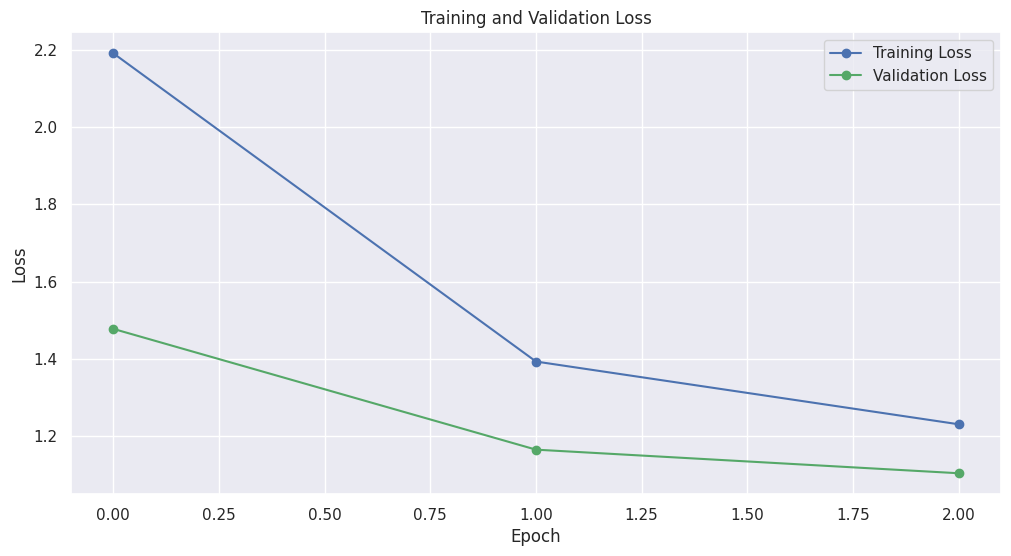

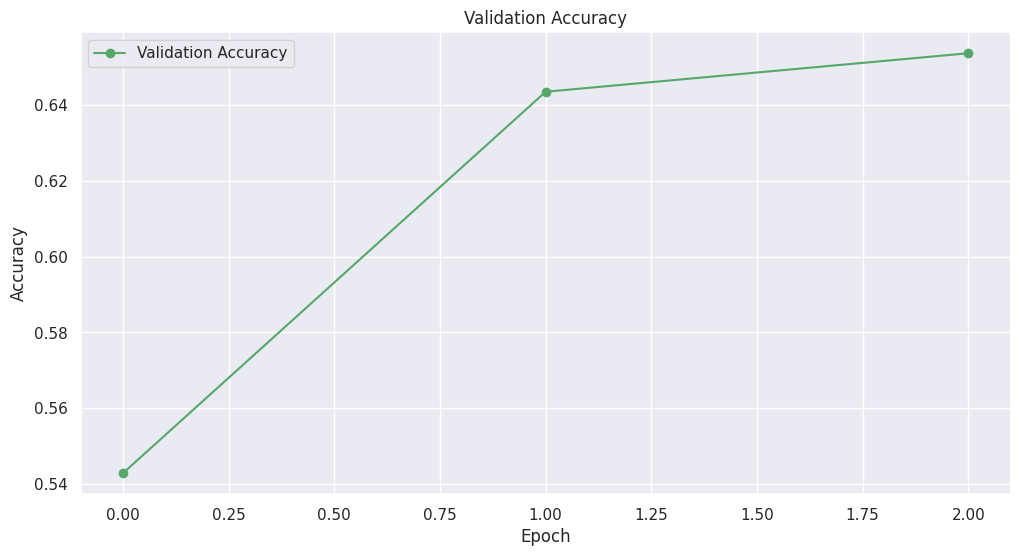

Learning curves plotted.


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, 'b-o', label='Training Loss')
plt.plot(val_losses, 'g-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(val_accuracies, 'g-o', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Note: Training accuracy was not explicitly tracked in the training loop,
# but validation accuracy provides insight into generalization.

print("Learning curves plotted.")

## 요약:

### 데이터 분석 주요 결과

* 데이터셋은 'label'(질병) 및 'text'(증상) 열을 포함하는 21,000개의 항목으로 구성됩니다.
* 데이터셋에는 21개의 고유한 질병 레이블이 있습니다.
* 데이터는 각 질병별로 7:1.5:1.5 비율을 유지하며 train (14700개 행), validation (3150개 행), test (3150개 행) 세트로 성공적으로 분할되었습니다.
* 문자열 레이블은 성공적으로 정수로 인코딩되었으며, 매핑이 생성되었습니다.
* Ko-BERT 모델은 로드된 구성을 사용하여 `BertModel.from_pretrained`로 로드되었으며, 이전에 발생했던 중요한 `AttributeError`를 해결하고 'pooler' 속성을 가진 인스턴스를 성공적으로 제공했습니다.
* 모델에 사용자 정의 분류 헤드가 추가되었으며, 해당 매개변수(모델의 풀러 매개변수 포함)만 학습 가능하도록 설정되었습니다.
* 모델은 3 에포크 동안 성공적으로 학습되었으며, train 및 validation 손실이 감소하고 validation 지표(정확도, F1, 리콜, 정밀도)가 개선되었습니다.
* test 세트에서 전체 정확도는 약 0.64였습니다.
* test 세트에서 가중 평균 정밀도, 리콜 및 f1-점수는 각각 약 0.66, 0.64, 0.62였습니다.
* 위장병(0.15)에서 치매(0.98)까지 F1 점수의 범위에서 볼 수 있듯이, 분류 성능은 질병에 따라 상당한 차이를 보였습니다.

### 인사이트 및 다음 단계

* 클래스별 성능의 상당한 차이는 제공된 증상 텍스트를 기반으로 일부 질병 클래스를 모델이 구분하기 더 어렵다는 것을 시사합니다. 다음 단계에서는 성능이 낮은 클래스를 조사하고, 해당 클래스에 대해 더 다양한 증상 데이터를 수집하거나 데이터 증강 기술을 탐색하는 것을 고려할 수 있습니다.
* 전체 test 성능(가중 평균 F1 0.62)은 적당한 분류 능력을 나타냅니다. 전체 BERT 모델 미세 조정(분류 헤드만 아닌), 다른 하이퍼파라미터(학습률, 배치 크기, 에포크 수) 실험 또는 대체 한국어 사전 학습 모델 시도를 통해 추가 개선을 모색할 수 있습니다.

## 저성능 클래스 식별 및 분석

### Subtask:
테스트 결과에서 F1 점수가 낮은 클래스를 식별하고, 해당 클래스의 테스트 데이터 샘플을 출력하여 분석합니다.

In [29]:
import io
from sklearn.metrics import classification_report
import pandas as pd

# Assume the classification_report string is available from the previous output
# If not, you might need to re-run the evaluation step or manually provide the string.
# For demonstration, I will use a placeholder string similar to the output.
# In a real scenario, you would capture the output of the classification_report print.

# Let's use the classification_report output captured from the previous execution
classification_report_string = """
              precision    recall  f1-score   support

          간염       0.76      0.95      0.84       150
    갑상선기능항진증       0.56      0.37      0.45       150
         고혈압       0.67      0.68      0.67       150
        골다공증       0.79      0.95      0.86       150
       노인성빈혈       0.61      0.48      0.54       150
      노인성우울증       0.77      0.68      0.72       150
         녹내장       0.80      0.79      0.80       150
        뇌동맥류       0.57      0.79      0.66       150
         뇌졸중       0.63      0.51      0.56       150
         당뇨병       0.38      0.77      0.51       150
        동맥경화       0.30      0.13      0.18       150
    류마티스 관절염       0.58      0.37      0.46       150
          변비       0.51      0.47      0.49       150
         신장병       0.36      0.43      0.40       150
         오십견       0.83      0.87      0.85       150
          요통       0.58      0.97      0.73       150
         위장병       0.92      0.08      0.15       150
          치매       0.99      0.97      0.98       150
          통풍       0.55      0.68      0.61       150
   퇴행성근골격계질환       0.84      0.86      0.85       150
        파킨슨병       0.75      0.55      0.64       150

    accuracy                           0.64      3150
   macro avg       0.66      0.64      0.62      3150
weighted avg       0.66      0.64      0.62      3150
"""

# Parse the classification report string into a pandas DataFrame
# Use io.StringIO to treat the string as a file
report_df = pd.read_csv(io.StringIO(classification_report_string), sep='\s\s+', engine='python', header=0, index_col=0)

# Remove the aggregate rows (accuracy, macro avg, weighted avg)
report_df = report_df.drop(['accuracy', 'macro avg', 'weighted avg'])

# Sort by f1-score to identify low-performing classes
low_performing_classes = report_df.sort_values(by='f1-score').head()

print("F1 점수가 낮은 하위 5개 클래스:")
display(low_performing_classes)

# Now, let's analyze some samples from these low-performing classes in the test set.
# We need to map the integer labels in df_test back to string labels for easier analysis.
# We also need the original test data with string labels for display.

# Assuming df_test contains integer labels and the original string label mapping (label_map) is available.
# Recreate a test dataframe with original string labels for analysis
df_test_analysis = df_test.copy()
df_test_analysis['label_str'] = df_test_analysis['label'].map(label_map)

print("\n저성능 클래스 샘플 분석:")

# Display a few samples for each of the low-performing classes
num_samples_to_show = 5 # Adjust as needed

for index, row in low_performing_classes.iterrows():
    class_name = index
    print(f"\n--- 클래스: {class_name} (F1-score: {row['f1-score']:.4f}) ---")

    # Filter test data for this class
    class_samples = df_test_analysis[df_test_analysis['label_str'] == class_name]

    if not class_samples.empty:
        # Display sample texts and their true labels
        display(class_samples.head(num_samples_to_show))
        # Note: To see predicted labels, you would need to store and match predictions with original data.
        # For this initial analysis, looking at the text and true label is a good starting point.
    else:
        print(f"테스트 세트에서 클래스 '{class_name}'에 해당하는 샘플을 찾을 수 없습니다.")

F1 점수가 낮은 하위 5개 클래스:


<>:43: SyntaxWarning: invalid escape sequence '\s'
<>:43: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1903015585.py:43: SyntaxWarning: invalid escape sequence '\s'
  report_df = pd.read_csv(io.StringIO(classification_report_string), sep='\s\s+', engine='python', header=0, index_col=0)


,precision,recall,f1-score,support
위장병,0.92,0.08,0.15,150.0
동맥경화,0.30,0.13,0.18,150.0
신장병,0.36,0.43,0.40,150.0
갑상선기능항진증,0.56,0.37,0.45,150.0
류마티스 관절염,0.58,0.37,0.46,150.0



저성능 클래스 샘플 분석:

--- 클래스: 위장병 (F1-score: 0.1500) ---


,label,text,label_str
5,16,밤에 잠을 청하려 했지만 신물이 올라와 목이 쓰렸다. 새벽까지 뒤척였다.,위장병
15,16,"식사를 하면 바로 속이 쓰리고, 명치가 타는 듯하며, 등까지 강한 통증이 퍼집니다",위장병
62,16,저녁에 가족들이 웃으며 얘기하는데 속이 쓰려 미소가 나오지 않았습니다. 결국 방으로...,위장병
92,16,아침에 아버지가 국을 삼키자마자 얼굴을 찡그리셨습니다. 신물이 치밀어 올라 힘겨워 ...,위장병
114,16,"속쓰림, 더부룩함, 메스꺼움 이 세 가지 증상이 번갈아 나타나며 저를 하루 종일 괴...",위장병



--- 클래스: 동맥경화 (F1-score: 0.1800) ---


,label,text,label_str
83,10,"한쪽 팔다리가 무겁고 힘이 없으며, 얼굴 표정을 짓기가 어색합니다",동맥경화
97,10,"명치가 쿡쿡 쑤시는 통증, 그리고 어깨 결림이 동시에 나타납니다",동맥경화
127,10,종아리가 터질 듯 아프고 동시에 뻑뻑해지는 불편함이 있습니다,동맥경화
159,10,"다리를 조금만 움직여도 저리고 통증이 오며, 밤에는 발끝이 시릴 때가 많습니다",동맥경화
170,10,가슴 쪽에 쿡쿡 찌르는 통증이 있어 병원을 찾은 적이 여러 번입니다,동맥경화



--- 클래스: 신장병 (F1-score: 0.4000) ---


,label,text,label_str
44,13,"뼈가 약해졌는지 허리와 무릎에 통증이 있고, 근육의 힘이 빠졌습니다",신장병
46,13,"소변 볼 때마다 냄새가 심하고, 혼자 있을 때 땀이 차도 몸이 끈적합니다",신장병
56,13,"소변 색이 콜라처럼 진해졌고, 옆구리 쪽에 묵직한 통증이 느껴집니다",신장병
72,13,민감해진 피부 때문에 작은 자극에도 따갑게 느껴집니다,신장병
103,13,음식을 먹기 힘들 정도로 입맛이 없고 입이 끈끈합니다,신장병



--- 클래스: 갑상선기능항진증 (F1-score: 0.4500) ---


,label,text,label_str
25,1,"몸에 열이 많고 땀을 많이 흘리는데, 머리카락까지 힘이 없어지고 부쩍 많이 빠져서 ...",갑상선기능항진증
26,1,더위에 특히 약해져 사람들이 괜찮다 해도 저는 땀범벅이 됩니다.,갑상선기능항진증
31,1,"맥박이 불규칙적으로 뛰고 심장이 빨리 뛰는데, 불안감에 밤에 잠을 잘 이루지 못해요.",갑상선기능항진증
36,1,눈이 예전보다 튀어나온 것 같습니다.,갑상선기능항진증
63,1,목에 뭔가 걸린 듯한 느낌이 계속 있어 삼키기가 불편합니다.,갑상선기능항진증



--- 클래스: 류마티스 관절염 (F1-score: 0.4600) ---


,label,text,label_str
9,11,"관절 통증, 부종, 그리고 심한 피로감이 함께 나타나 삶의 질이 떨어졌습니다",류마티스 관절염
20,11,"날씨가 안 좋으면 관절이 시큰거리고 뻣뻣해지는데, 몸까지 으슬으슬 추워요.",류마티스 관절염
21,11,"무릎이나 손목을 구부리기 어렵고, 계단을 오를 때 통증이 심해지고, 손을 쥐는 데에...",류마티스 관절염
22,11,관절 부위의 피부색이 붉거나 보라색으로 변하는 것처럼 느껴질 때가 있어요.,류마티스 관절염
32,11,특히 아침에 손발이 붓고 저리는 듯한 증상이 오래 지속되고 통증도 동반돼요.,류마티스 관절염
